In [2]:
import pandas as pd

In [3]:
purch_data = pd.read_csv('purchase.csv')

Using glm

In [4]:
import statsmodels.api as sm

# Define the independent variable (with a constant for the intercept)
X = sm.add_constant(purch_data['idx'])

# Define the dependent variable
y = purch_data['purchase']

# Fit the GLM model with a binomial family (logistic regression)
glm_model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
glm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               purchase   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -769.29
Date:                Fri, 02 May 2025   Deviance:                       1538.6
Time:                        14:38:29   Pearson chi2:                 2.03e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06354
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2196      0.160    -20.175      0.000      -3.532      -2.907
idx            0.0325      0.003     11.142      0.000       0.027       0.038
==============================================================================
"""

In [5]:

# Calculate the confidence intervals
confidence_intervals = glm_model.conf_int()
print(confidence_intervals)

              0         1
const -3.532406 -2.906838
idx    0.026805  0.038249


using manual method for MLE and calculating standard errors


You want to compute the standard errors of the estimated coefficients from your manual MLE (maximum likelihood estimation) of logistic regression.

In statistics, standard errors indicate how precise your parameter estimates are — they’re derived from the curvature (second derivatives) of the likelihood function, i.e., the Hessian matrix.

When using scipy.optimize.minimize(), the result object can include the inverse Hessian (hess_inv), which approximates the covariance matrix of the estimated coefficients.

The Hessian is the matrix of second derivatives of the negative log-likelihood function

The diagonal of the inverse Hessian gives the variance estimates of the coefficients.

Taking the square root gives the standard errors.

These are directly comparable to what glm_model.bse gives in the built-in statsmodels logistic regression.

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm

# Prepare data
X = sm.add_constant(purch_data[['idx']])
y = purch_data['purchase']

X_np = X.values
y_np = y.values

# Define the negative log-likelihood function
def neg_log_likelihood(beta, X, y):
    z = np.dot(X, beta)
    pi = 1 / (1 + np.exp(-z))
    pi = np.clip(pi, 1e-8, 1 - 1e-8)
    ll = np.sum(y * np.log(pi) + (1 - y) * np.log(1 - pi))
    return -ll

# Define the gradient (first derivative)
def grad_neg_log_likelihood(beta, X, y):
    pi = 1 / (1 + np.exp(-np.dot(X, beta)))
    return -np.dot(X.T, y - pi)

# Define the Hessian (second derivative)
def hess_neg_log_likelihood(beta, X):
    pi = 1 / (1 + np.exp(-np.dot(X, beta)))
    W = np.diag(pi * (1 - pi))
    return np.dot(X.T, np.dot(W, X))

# Initial guess
initial_beta = np.zeros(X.shape[1])

# Run minimization with gradient and Hessian
result = minimize(
    neg_log_likelihood,
    initial_beta,
    args=(X_np, y_np),
    method='Newton-CG',
    jac=grad_neg_log_likelihood,
    hess=lambda b, X, y: hess_neg_log_likelihood(b, X),
    options={'xtol': 1e-8, 'disp': True}
)

# Estimated coefficients
beta_hat = result.x
print("Estimated coefficients:", beta_hat)

# Compute Hessian at optimum
hessian = hess_neg_log_likelihood(beta_hat, X_np)

# Invert Hessian to get variance-covariance matrix
cov_matrix = np.linalg.inv(hessian)
standard_errors = np.sqrt(np.diag(cov_matrix))
print("Standard errors (manual):", standard_errors)

# 95% confidence intervals
z = norm.ppf(0.975)
lower = beta_hat - z * standard_errors
upper = beta_hat + z * standard_errors

for i, (l, u) in enumerate(zip(lower, upper)):
    print(f"95% CI for beta_{i}: ({l:.4f}, {u:.4f})")


Optimization terminated successfully.
         Current function value: 769.287143
         Iterations: 23
         Function evaluations: 37
         Gradient evaluations: 37
         Hessian evaluations: 23
Estimated coefficients: [-3.21962193  0.03252663]
Standard errors (manual): [0.15958658 0.00291937]
95% CI for beta_0: (-3.5324, -2.9068)
95% CI for beta_1: (0.0268, 0.0382)


Bootstrap method

In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Setup
X = sm.add_constant(purch_data[['idx']])
y = purch_data['purchase']
X_np = X.values
y_np = y.values

# Store slope coefficient (index 1 because index 0 is intercept)
slope_boot = []

# Bootstrap parameters
n_boot = 1000
np.random.seed(42)

for _ in range(n_boot):
    # Sample with replacement
    idx_sample = np.random.choice(len(y_np), size=len(y_np), replace=True)
    X_sample = X_np[idx_sample]
    y_sample = y_np[idx_sample]

    # Fit model on bootstrap sample
    def neg_log_likelihood(beta, X, y):
        pi = 1 / (1 + np.exp(-np.dot(X, beta)))
        pi = np.clip(pi, 1e-8, 1 - 1e-8)
        ll = np.sum(y * np.log(pi) + (1 - y) * np.log(1 - pi))
        return -ll

    res = minimize(
        neg_log_likelihood,
        x0=np.zeros(X_np.shape[1]),
        args=(X_sample, y_sample),
        method='BFGS'
    )

    # Store slope coefficient (beta[1])
    if res.success:
        slope_boot.append(res.x[1])

slope_boot = np.array(slope_boot)


In [10]:
slope_mean = np.mean(slope_boot)
slope_std = np.std(slope_boot, ddof=1)  # sample std dev
z = 1.96  # 95% CI

ci_std = (slope_mean - z * slope_std, slope_mean + z * slope_std)
print(f"Bootstrap CI (Std Dev approach): {ci_std}")


Bootstrap CI (Std Dev approach): (0.0271818769043601, 0.037844233597841)


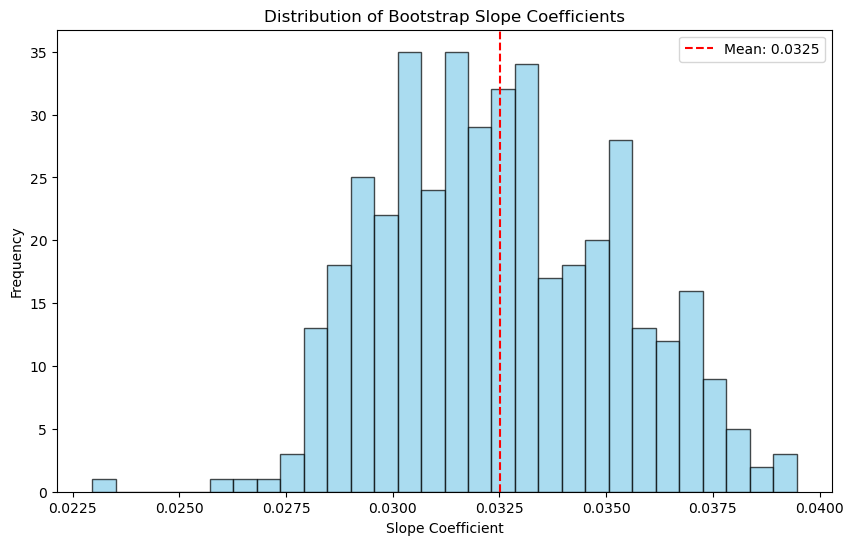

In [12]:
import numpy as np

import matplotlib.pyplot as plt

# Plot 1: Distribution of bootstrap slope coefficients
plt.figure(figsize=(10, 6))
plt.hist(slope_boot, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(slope_mean, color='red', linestyle='--', label=f'Mean: {slope_mean:.4f}')
plt.title('Distribution of Bootstrap Slope Coefficients')
plt.xlabel('Slope Coefficient')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In class 2

In [13]:
maxdiff = pd.read_excel('maxdiff.xlsx')

In [22]:
# Count the occurrences of each Response value for each Item
response_counts = maxdiff.groupby(['Item', 'Response']).size().unstack(fill_value=0)

# Rename the columns for clarity
response_counts.columns = ['Count of -1', 'Count of 0', 'Count of 1']
# Sort the response_counts DataFrame by 'Count of 1' in descending order
response_counts = response_counts.sort_values(by=['Count of -1'], ascending=False)
print(response_counts)

      Count of -1  Count of 0  Count of 1
Item                                     
4              49          39          14
1              41          42          22
7              32          46          24
3              31          54          14
11             31          57          15
8              26          19          58
10             25          62          15
6              20          37          43
12             17          43          45
9              16          77          10
13             16          78           9
2              15          63          23
5              14          49          41
